In [18]:
from IPython.core.display import HTML, display
import pickle
from warnings import filterwarnings
from datetime import datetime as DT

import pymc3 as pm
import theano.tensor as tt
from theano import shared

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from seaborn import heatmap
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter
from cmocean import cm as cmo

from pymc_utils import PyMCModel
from pymc_utils import Ordered
from pymc_utils import subset_significant_feature

In [2]:
filterwarnings('ignore', category=UserWarning)

In [3]:
display(HTML("<style>.container {width: 90% !important}</style>"))

In [4]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['text.usetex'] = False

In [5]:
def bayes_nn_model_l1_h(X, y_obs, n_hidden=None, lklhd_name='likelihood'):
    """
    Hierarchical Bayesian NN Implementation with ARD.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    
    if n_hidden is None:
        n_hidden = num_feats
    testvals = np.sort(np.random.randn(n_hidden))
    with pm.Model() as model:
        
        hyp_wi1_sd = pm.HalfCauchy('hyp_w_i_1_sd', beta=.1, shape=(num_feats,1))
        hyp_w1o_sd = pm.HalfCauchy('hyp_w_1_out_sd', beta=.1)
        hyp_bias_1_sd = pm.HalfCauchy('hyp_bias_1_sd', beta=.1)
         
        w_i_1_intrmd = pm.Normal('wts_i_1_intrmd', mu=0, sd=1, shape=(num_feats, n_hidden))
        w_1_o_intrmd = pm.Normal('wts_1_o_intrmd', mu=0, sd=1, shape=(n_hidden,))
        
        w_i_1 = pm.Deterministic('wts_i_1', w_i_1_intrmd * hyp_wi1_sd)
        w_1_o = pm.Deterministic('wts_1_out', w_1_o_intrmd * hyp_w1o_sd)
        b_1 = pm.Normal('bias_1', mu=0, sd=hyp_bias_1_sd, shape=(n_hidden))
        b_o = pm.Normal('bias_o', mu=0, sd=1)
        lyr1_act = pm.Deterministic('layer1_act', pm.math.theano.tensor.nnet.elu(tt.dot(X, w_i_1) + b_1) )
        out_act = pm.Deterministic('out_act', tt.dot(lyr1_act, w_1_o) + b_o)
        
        sd = pm.HalfCauchy('sd', beta=1)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [6]:
def bayes_nn_model_l1_h_bias_constrained(X, y_obs, n_hidden=None, lklhd_name='likelihood'):
    """
    Hierarchical Bayesian NN Implementation with ARD.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    
    if n_hidden is None:
        n_hidden = num_feats
    testvals = np.sort(np.random.randn(n_hidden))
    with pm.Model() as model:
        
        hyp_wi1_sd = pm.HalfCauchy('hyp_w_i_1_sd', beta=.1, shape=(num_feats,1))
        hyp_w1o_sd = pm.HalfCauchy('hyp_w_1_out_sd', beta=.1)
        hyp_bias_1_sd = pm.HalfCauchy('hyp_bias_1_sd', beta=.1)
         
        w_i_1_intrmd = pm.Normal('wts_i_1_intrmd', mu=0, sd=1, shape=(num_feats, n_hidden))
        w_1_o_intrmd = pm.Normal('wts_1_o_intrmd', mu=0, sd=1, shape=(n_hidden,))
        
        w_i_1 = pm.Deterministic('wts_i_1', w_i_1_intrmd * hyp_wi1_sd)
        w_1_o = pm.Deterministic('wts_1_out', w_1_o_intrmd * hyp_w1o_sd)
        b_1 = pm.Normal('bias_1', mu=0, sd=hyp_bias_1_sd, shape=(n_hidden),
                       transform=pm.distributions.transforms.Ordered(), testval=testvals)
        b_o = pm.Normal('bias_o', mu=0, sd=1)
        lyr1_act = pm.Deterministic('layer1_act', pm.math.theano.tensor.nnet.elu(tt.dot(X, w_i_1) + b_1) )
        out_act = pm.Deterministic('out_act', tt.dot(lyr1_act, w_1_o) + b_o)
        
        sd = pm.HalfCauchy('sd', beta=1)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [7]:
def bayes_nn_model_l1_h_constrained(X, y_obs, n_hidden=None, lklhd_name='likelihood'):
    """
    Hierarchical Bayesian NN Implementation with ARD.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    
    if n_hidden is None:
        n_hidden = num_feats
    testval_bias = np.sort(np.random.randn(n_hidden))
    testval_wi1 = np.sort(np.random.randn(num_feats, n_hidden))
    with pm.Model() as model:
        
        hyp_wi1_sd = pm.HalfCauchy('hyp_w_i_1_sd', beta=.1, shape=(num_feats,1))
        hyp_w1o_sd = pm.HalfCauchy('hyp_w_1_out_sd', beta=.1)
        hyp_bias_1_sd = pm.HalfCauchy('hyp_bias_1_sd', beta=.1)
         
        w_i_1_intrmd = pm.Normal('wts_i_1_intrmd', mu=0, sd=1, shape=(num_feats, n_hidden),
                                transform=pm.distributions.transforms.Ordered(),
                                testval=testval_wi1,
                                )
        w_1_o_intrmd = pm.Normal('wts_1_o_intrmd', mu=0, sd=1, shape=(n_hidden),
                                #transform=pm.distributions.transforms.Ordered(),
                                #testval=testvals,
                                )
        
        w_i_1 = pm.Deterministic('wts_i_1', w_i_1_intrmd * hyp_wi1_sd)
        w_1_o = pm.Deterministic('wts_1_out', w_1_o_intrmd * hyp_w1o_sd)
        b_1 = pm.Normal('bias_1', mu=0, sd=hyp_bias_1_sd, shape=(n_hidden),
                       transform=pm.distributions.transforms.Ordered(), testval=testval_bias)
        b_o = pm.Normal('bias_o', mu=0, sd=1)
        lyr1_act = pm.Deterministic('layer1_act', pm.math.theano.tensor.nnet.elu(tt.dot(X, w_i_1) + b_1) )
        out_act = pm.Deterministic('out_act', tt.dot(lyr1_act, w_1_o) + b_o)
        
        sd = pm.HalfCauchy('sd', beta=1)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [8]:
def bayes_nn_model_l1_h_more_constrained(X, y_obs, n_hidden=None, lklhd_name='likelihood'):
    """
    Hierarchical Bayesian NN Implementation with ARD.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    
    if n_hidden is None:
        n_hidden = num_feats
    testval_bias = np.sort(np.random.randn(n_hidden))
    testval_wi1 = np.sort(np.random.randn(num_feats, n_hidden))
    with pm.Model() as model:
        
        hyp_wi1_sd = pm.HalfNormal('hyp_w_i_1_sd', sd=.1, shape=(num_feats,1))
        hyp_w1o_sd = pm.HalfNormal('hyp_w_1_out_sd', sd=.1)
        hyp_bias_1_sd = pm.HalfNormal('hyp_bias_1_sd', sd=.1)
         
        w_i_1_intrmd = pm.Normal('wts_i_1_intrmd', mu=0, sd=1, shape=(num_feats, n_hidden),
                                transform=pm.distributions.transforms.Ordered(),
                                testval=testval_wi1,
                                )
        w_1_o_intrmd = pm.Normal('wts_1_o_intrmd', mu=0, sd=1, shape=(n_hidden),
                                #transform=pm.distributions.transforms.Ordered(),
                                #testval=testvals,
                                )
        
        w_i_1 = pm.Deterministic('wts_i_1', w_i_1_intrmd * hyp_wi1_sd)
        w_1_o = pm.Deterministic('wts_1_out', w_1_o_intrmd * hyp_w1o_sd)
        b_1 = pm.Normal('bias_1', mu=0, sd=hyp_bias_1_sd, shape=(n_hidden),
                       transform=pm.distributions.transforms.Ordered(), testval=testval_bias)
        b_o = pm.Normal('bias_o', mu=0, sd=1)
        lyr1_act = pm.Deterministic('layer1_act', pm.math.theano.tensor.nnet.elu(tt.dot(X, w_i_1) + b_1) )
        out_act = pm.Deterministic('out_act', tt.dot(lyr1_act, w_1_o) + b_o)
        
        sd = pm.HalfCauchy('sd', beta=1)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [9]:
def plot_pairwise_corr(df_, ax=None, **heatmap_kwgs):
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 10))
    heatmap(df_.corr().iloc[1:,:-1],vmin=-1, vmax=1,
            mask=np.triu(np.ones([df_.shape[1]-1] * 2),k=1),
            ax=ax, **heatmap_kwgs,
            #annot=True, annot_kws={'fontsize': 10}, cmap=cmo.balance_r
           )
    ax.set_facecolor('k')
    return ax

In [10]:
def plot_fits_w_estimates(y_obs, ppc, ax=None, savename=False):
    """ Plot Fits with Uncertainty Estimates"""
    iy  = np.argsort(y_obs)
    ix = np.arange(iy.size)
    lik_mean =ppc.mean(axis=0)
    lik_hpd = pm.hpd(ppc)
    lik_hpd_05 = pm.hpd(ppc, alpha=0.5)
    r2 = r2_score(y_obs, lik_mean)
    mae = mean_absolute_error(y_obs, lik_mean)
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 8))
    ax.scatter(ix, y_obs.values[iy], label='observed', edgecolor='k', s=100,
               color='steelblue', marker='d', zorder=2);
    ax.scatter(ix, lik_mean[iy], label='model mean -- $r^2$=%.2f -- mae=%.2f' %(r2, mae),
               edgecolor='k', s=100, color='m', zorder=3)

    ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], color='gray', 
                   label='model output 50%CI', zorder=1,linestyle='-', lw=2, edgecolor='k');
    ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], color='k', alpha=0.75,
                   label='model output 95%CI', zorder=0, );
    ax.legend(loc='upper left');
    if savename:
        f = pl.gcf()
        f.savefig('./figJar/bayesNet/%s.pdf' % savename, format='pdf')
    return ax

In [24]:
def plot_obs_against_ppc(y_obs, ppc, ax=None, plot_1_to_1=False, **scatter_kwds):
    if ax is None:
        _, ax = pl.subplots(figsize=(10, 10))
    ppc_mean = ppc.mean(axis=0)
    mae = mean_absolute_error(y_obs, ppc_mean)
    r2 = r2_score(y_obs, ppc_mean)
    
    scatter_lbl = f'$r^2$={r2:.2f}, mae={mae:.2f}'
    scatter_lbl = scatter_kwds.pop('label', scatter_lbl)
    ax.scatter(y_obs, ppc_mean, edgecolor='k', label=scatter_lbl, **scatter_kwds)
    if plot_1_to_1:
        min_ = min(ppc_mean.min(), y_obs.min())
        max_ = max(ppc_mean.max(), y_obs.max())
        ax.plot([min_, max_], [min_, max_], ls='--', color='k', label='1:1')
    ax.legend(loc='upper left')
    return ax

def uncertainty_plot_2(ppc_train, ppc_test, y_test_, y_train_, ax, band_color,
                      scatter_zorder=2, hpd_zorder=0, hpd_50_zorder=1):
    ix_ = np.argsort(y_train_)
    hpd_50 = pm.hpd(ppc_train[:, ix_], alpha=0.5)
    hpd = pm.hpd(ppc_train[:, ix_],)
    mean_ = ppc_train[:, ix_].mean(axis=0)
    mean_test_ = ppc_test.mean(axis=0)
    ax.scatter(mean_test_, y_test_, edgecolor='k', lw=2, zorder=scatter_zorder, color=band_color, s=50)
    ax.fill_betweenx(mean_, x1=hpd[:, 0], x2=hpd[:, 1], alpha=0.25, zorder=hpd_zorder, color=band_color)
    ax.fill_betweenx(mean_, x1=hpd_50[:, 0], x2=hpd_50[:, 1], alpha=0.25, color=band_color)

In [13]:
with open('./pickleJar/BNNAphySplitDataSets.pkl', 'rb') as fb:
    datadict = pickle.load(fb)

In [14]:
X_s_train, X_s_test, y_train, y_test = datadict['x_train_s'], datadict['x_test_s'], datadict['y_train'], datadict['y_test']

In [16]:
X_s_train.shape, X_s_test.shape, y_train.shape, y_test.shape

((145, 9), (17, 9), (145, 6), (17, 6))

### Fitting w/ All Features

### A$\phi$ 411

In [84]:
X_shared.set_value(X_s_train.values)
bnn_l1_4HL_411hn = PyMCModel(bayes_nn_model_l1_h_more_constrained, X_shared,
                             y_train.log10_aphy411, n_hidden=4,)
bnn_l1_4HL_411hn.fit(n_samples=2000, cores=2, chains=4, tune=12000,
                     nuts_kwargs=dict(target_accept=0.95,
                                      max_treedepth=11))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
Sampling 4 chains: 100%|██████████| 56000/56000 [24:16<00:00, 38.44draws/s] 
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


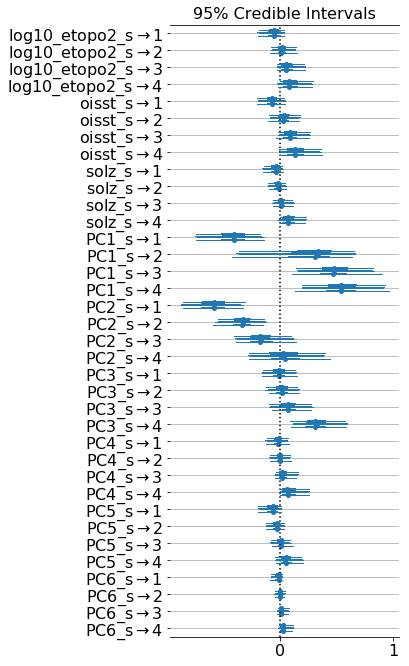

In [85]:
pm.forestplot(bnn_l1_4HL_411hn.trace_, varnames=['wts_i_1'], ylabels=forest_labels_4, rhat=False)
f = pl.gcf()
f.set_figheight(10)
ax = pl.gca()
ax.grid(axis='y')
f.savefig('./figJar/forestplot_181203/bnn_l1_4HL_411_hn_wts_i_1_forestplot_no_r.pdf',
          dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:02<00:00, 829.18it/s]


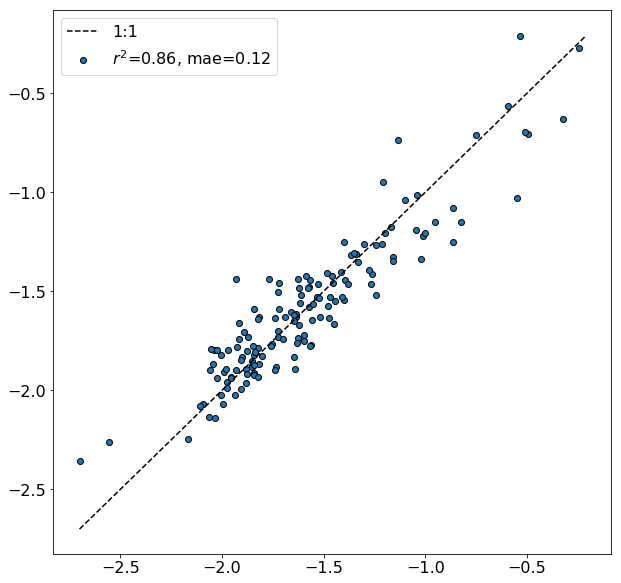

In [86]:
# Check fit on training model
ppc_train_l1_411hn = bnn_l1_4HL_411hn.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_train.log10_aphy411, ppc_train_l1_411hn, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/train_set_fits/bnn_l1_4HL_411hn.pdf', dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:03<00:00, 597.83it/s]


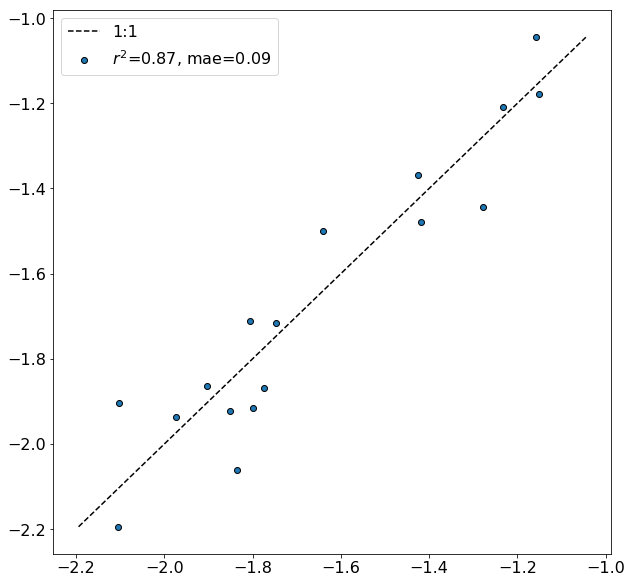

In [89]:
# Check fit on training model
X_shared.set_value(X_s_test)
ppc_test_l1_411hn = bnn_l1_4HL_411hn.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_test.log10_aphy411, ppc_test_l1_411hn, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/test_set_fits/bnn_l1_4HL_411hn.pdf', dpi=300, format='pdf')

### A$\phi$ 443

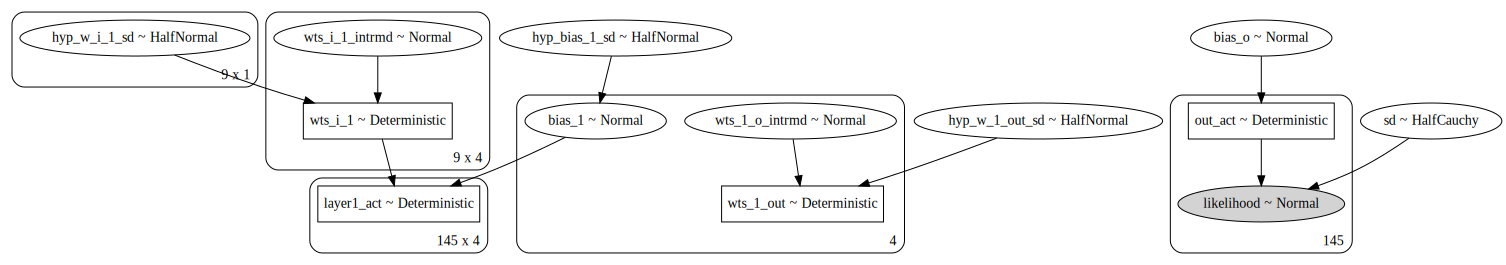

In [19]:
bnn_l1_4HL_443_hn = PyMCModel(bayes_nn_model_l1_h_more_constrained, X_shared, y_train.log10_aphy443, n_hidden=4,)
bnn_l1_4HL_443_hn.model.name = 'L1_4units_443_hnhp'
bnn_l1_4HL_443_hn.show_model()

In [21]:
bnn_l1_4HL_443_hn.fit(n_samples=2000, cores=2, chains=4,
                      tune=12000,  nuts_kwargs=dict(target_accept=0.95, max_treedepth=11)
                     )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
Sampling 4 chains: 100%|██████████| 56000/56000 [28:34<00:00, 32.67draws/s] 
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


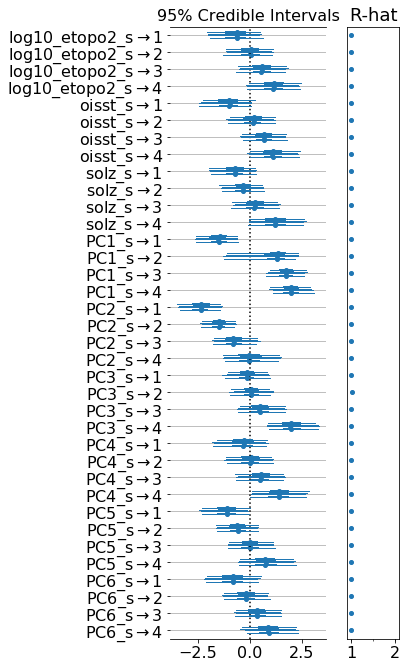

In [93]:
forest_labels_4 = [r'%s$\rightarrow$%d' %(feature, unit) for feature in X_s_train.columns for unit in range(1, 5)]
bnn_l1_4HL_443_hn.show_forest(['wts_i_1_intrmd'], feat_labels=forest_labels_4)
f = pl.gcf()
f.set_figheight(10)
f.savefig('./figJar/forestplot_181203/bnn_l1_4HL_443_hn_wts_i_1_intrmd_forestplot.pdf',
          dpi=300, format='pdf')

(-1.093081909421187, 1.093081909421187)

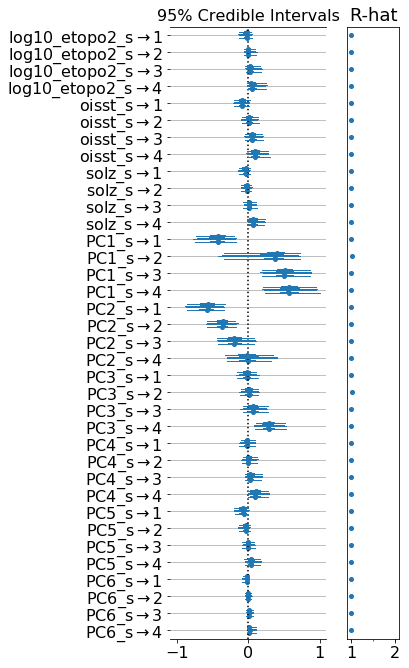

In [94]:
pm.forestplot(bnn_l1_4HL_443_hn.trace_, varnames=['wts_i_1'], ylabels=forest_labels_4, rhat=True)
f = pl.gcf()
f.set_figheight(10)
ax = pl.gca()
ax.grid(axis='y')
ax.set_xlim(-ax.get_xlim()[1], ax.get_xlim()[1])
#f.savefig('./figJar/forestplot_181203/bnn_l1_4HL_443_hn_wts_i_1_forestplot_no_r.pdf',
#          dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:02<00:00, 827.53it/s]


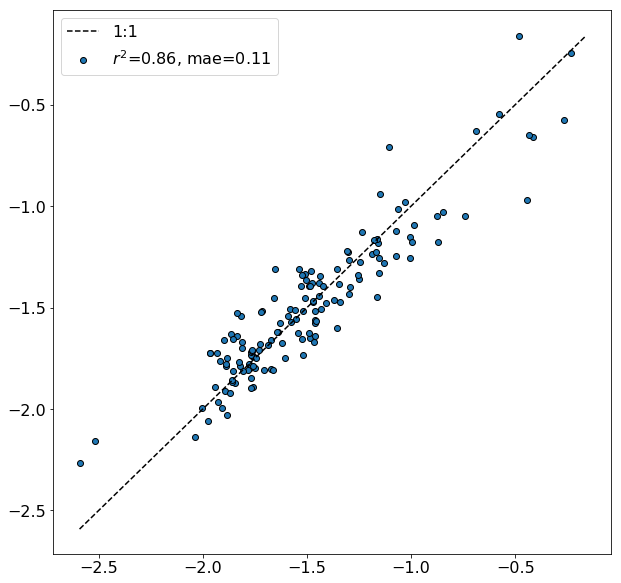

In [26]:
# Check fit on training model
ppc_train_l1_443hn = bnn_l1_4HL_443_hn.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_train.log10_aphy443, ppc_train_l1_443hn, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/train_set_fits/bnn_l1_4HL_443hn.pdf', dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:04<00:00, 480.92it/s]


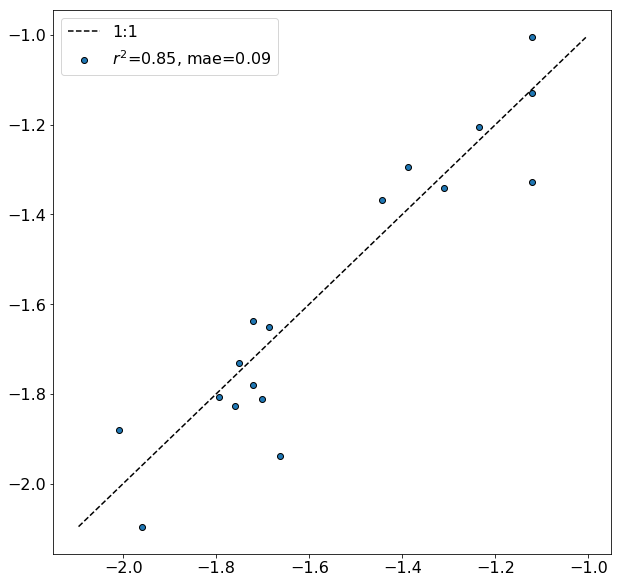

In [49]:
# Check Fit on Test Data
X_shared.set_value(X_s_test)
ppc_test_l1_443hn = bnn_l1_4HL_443_hn.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_test.log10_aphy443, ppc_test_l1_443hn, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/test_set_fits/bnn_l1_4HL_443_hn_test.pdf', dpi=300, format='pdf')

#### Checking fits on training data

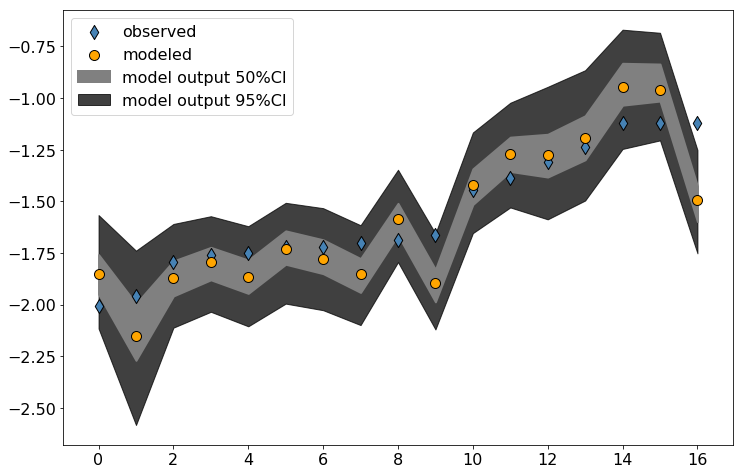

In [31]:
ax = plot_fits_w_estimates(y_test.log10_aphy443, ppc_test_443)

### A$\phi$_489

In [35]:
X_shared.set_value(X_s_train.values)
bnn_l1_4HL_489hn = PyMCModel(bayes_nn_model_l1_h_more_constrained, X_shared, y_train.log10_aphy489, n_hidden=4,)

In [36]:
bnn_l1_4HL_489hn.fit(n_samples=2000, cores=2, chains=4, tune=12000,
                   nuts_kwargs=dict(target_accept=0.95,max_treedepth=11))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
Sampling 4 chains: 100%|██████████| 56000/56000 [30:49<00:00, 15.13draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [65]:
ax.get_xlim()

(-0.9453703379584849, 1.2158968545065898)

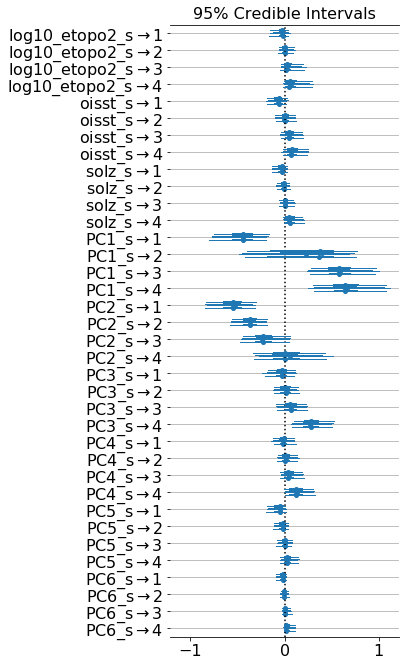

In [66]:
pm.forestplot(bnn_l1_4HL_489hn.trace_, varnames=['wts_i_1'], ylabels=forest_labels_4, rhat=False)
f = pl.gcf()
f.set_figheight(10)
ax = pl.gca()
ax.grid(axis='y')
ax.set_xlim(-ax.get_xlim()[1], ax.get_xlim()[1])
f.savefig('./figJar/forestplot_181203/bnn_l1_4HL_489_hn_wts_i_1_forestplot_no_r.pdf',
          dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:02<00:00, 833.78it/s]


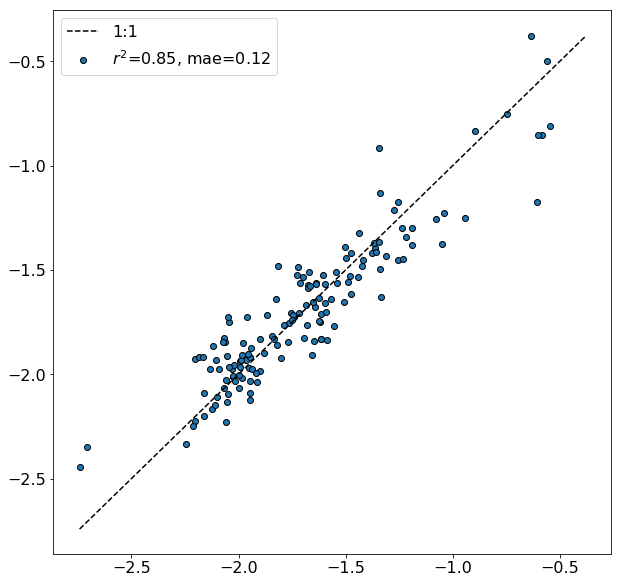

In [41]:
# Check fit on training model
X_shared.set_value(X_s_train)
ppc_train_l1_489hn = bnn_l1_4HL_489hn.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_train.log10_aphy489, ppc_train_l1_489hn, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/train_set_fits/bnn_l1_4HL_489hn.pdf', dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:04<00:00, 472.64it/s]


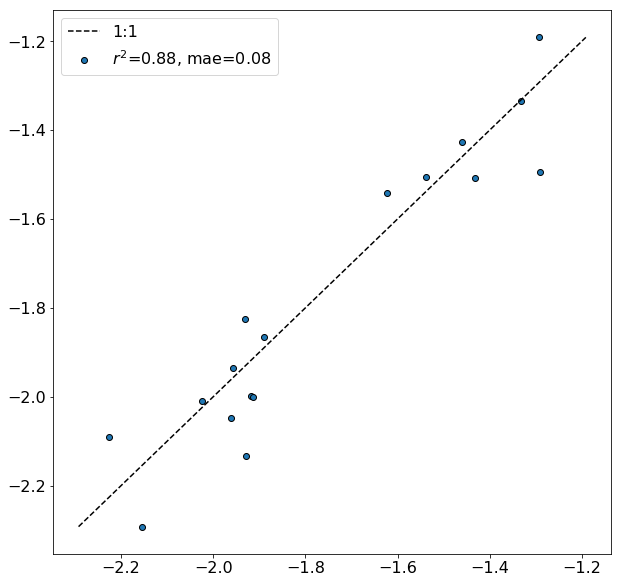

In [52]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l1_489hn = bnn_l1_4HL_489hn.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_test.log10_aphy489, ppc_test_l1_489hn, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/test_set_fits/bnn_l1_4HL_489hn.pdf', dpi=300, format='pdf')

### A$\phi$_510

In [44]:
X_shared.set_value(X_s_train.values)
bnn_l1_4HL_510hn = PyMCModel(bayes_nn_model_l1_h_more_constrained, X_shared, y_train.log10_aphy510, n_hidden=4,)
bnn_l1_4HL_510hn.fit(n_samples=2000, cores=1, chains=4, tune=12000,  nuts_kwargs=dict(target_accept=0.95,max_treedepth=11))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
100%|██████████| 14000/14000 [14:19<00:00, 16.28it/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 136 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


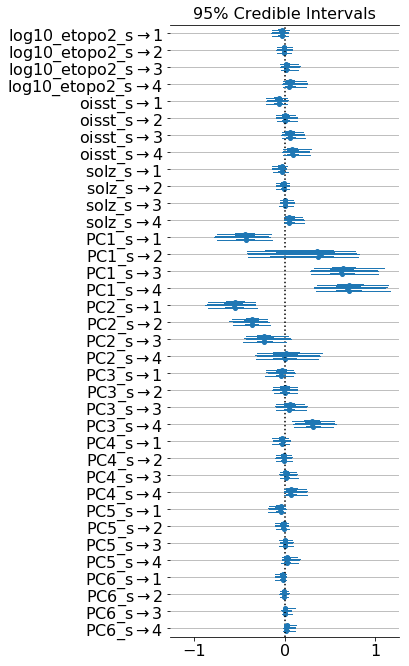

In [69]:
pm.forestplot(bnn_l1_4HL_510hn.trace_, varnames=['wts_i_1'], ylabels=forest_labels_4, rhat=False)
f = pl.gcf()
f.set_figheight(10)
ax = pl.gca()
ax.grid(axis='y')
ax.set_xlim(-ax.get_xlim()[1], ax.get_xlim()[1])
f.savefig('./figJar/forestplot_181203/bnn_l1_4HL_510_hn_wts_i_1_forestplot_no_r.pdf',
          dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:02<00:00, 783.02it/s]


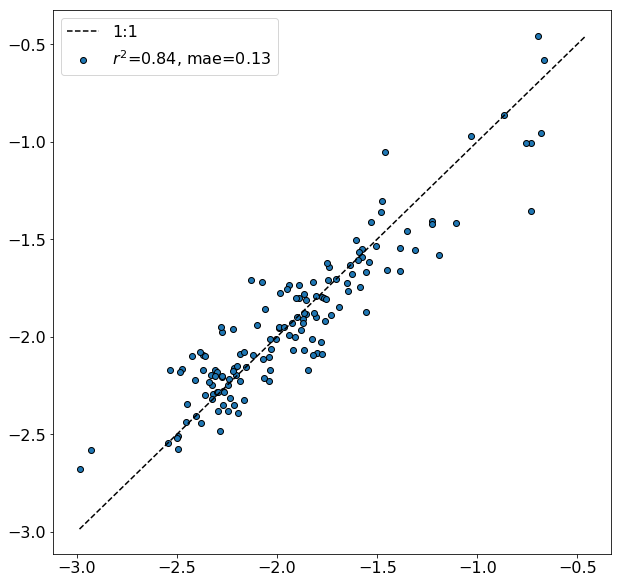

In [45]:
# Check fit on training model
X_shared.set_value(X_s_train)
ppc_train_l1_510hn = bnn_l1_4HL_510hn.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_train.log10_aphy510, ppc_train_l1_510hn, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/train_set_fits/bnn_l1_4HL_510hn.pdf', dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:03<00:00, 615.96it/s]


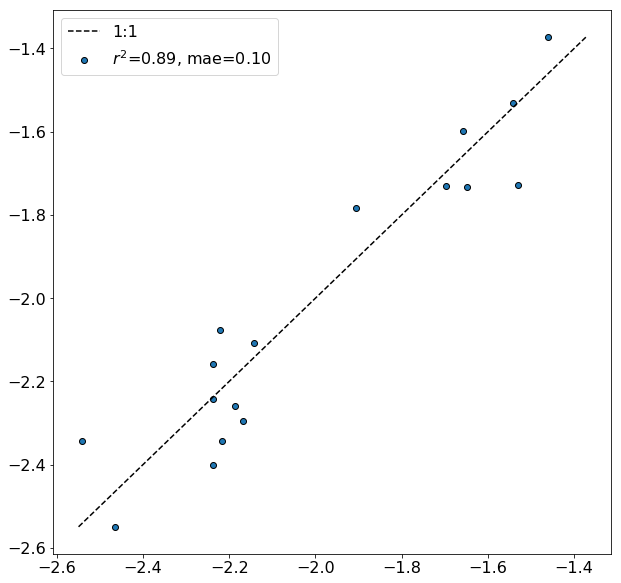

In [47]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l1_510hn = bnn_l1_4HL_510hn.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_test.log10_aphy510, ppc_test_l1_510hn, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/test_set_fits/bnn_l1_4HL_510hn.pdf', dpi=300, format='pdf')

### A$\phi$555

In [57]:
X_shared.set_value(X_s_train)
bnn_l1_4HL_555hn = PyMCModel(bayes_nn_model_l1_h_more_constrained, X_shared,
                           y_train.log10_aphy555, n_hidden=4,)

In [58]:
bnn_l1_4HL_555hn.fit(n_samples=2000, cores=2, chains=4, tune=12000,
                   nuts_kwargs=dict(target_accept=0.95,max_treedepth=11))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
Sampling 4 chains: 100%|██████████| 56000/56000 [15:54<00:00, 30.72draws/s] 
There were 617 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6814230506310559, but should be close to 0.95. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


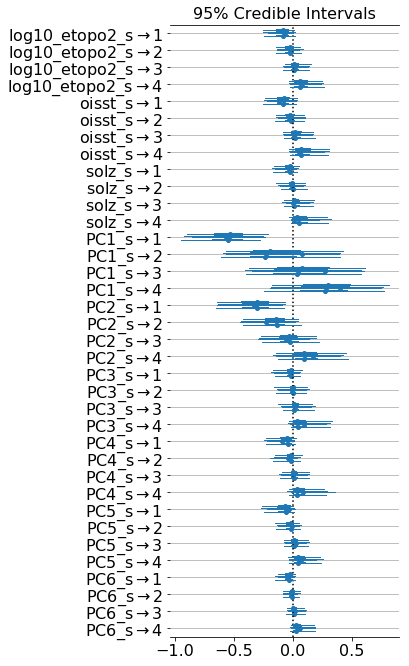

In [71]:
pm.forestplot(bnn_l1_4HL_555hn.trace_, varnames=['wts_i_1'], ylabels=forest_labels_4, rhat=False)
f = pl.gcf()
f.set_figheight(10)
ax = pl.gca()
ax.grid(axis='y')
f.savefig('./figJar/forestplot_181203/bnn_l1_4HL_555_hn_wts_i_1_forestplot_no_r.pdf',
          dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:03<00:00, 628.66it/s]


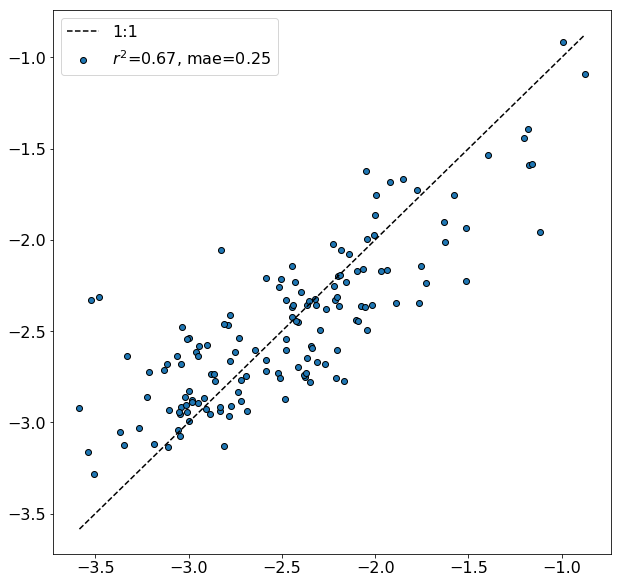

In [61]:
# Check fit on training model
X_shared.set_value(X_s_train)
ppc_train_l1_555hn = bnn_l1_4HL_555hn.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_train.log10_aphy555, ppc_train_l1_555hn, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/train_set_fits/bnn_l1_4HL_555hn.pdf', dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:04<00:00, 473.85it/s]


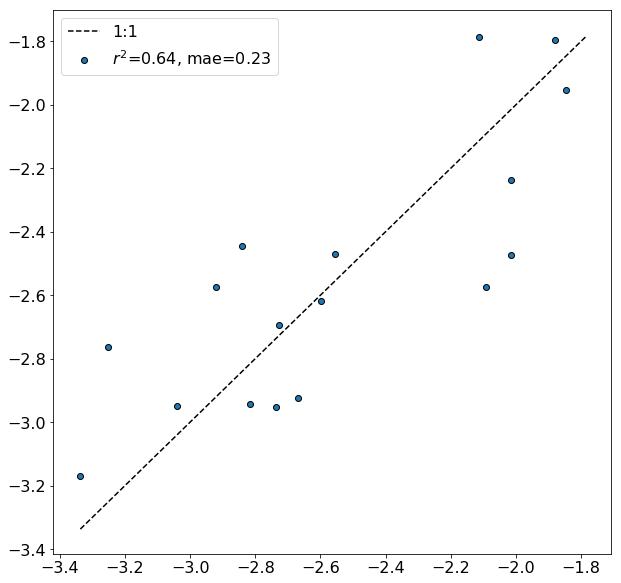

In [62]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l1_555hn = bnn_l1_4HL_555hn.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_test.log10_aphy555, ppc_test_l1_555hn, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/test_set_fits/bnn_l1_4HL_555hn.pdf', dpi=300, format='pdf')

### A$\phi$ 670

In [72]:
X_shared.set_value(X_s_train.values)
bnn_l1_4HL_670hn = PyMCModel(bayes_nn_model_l1_h_more_constrained, X_shared,
                             y_train.log10_aphy670, n_hidden=4,)
bnn_l1_4HL_670hn.fit(n_samples=2000, cores=1, chains=4, tune=12000,
                     nuts_kwargs=dict(target_accept=0.95,
                                      max_treedepth=11)
                    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
100%|██████████| 14000/14000 [20:20<00:00, 11.47it/s]
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


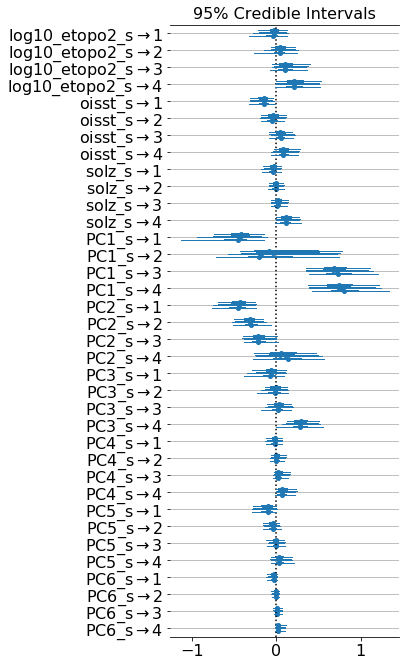

In [73]:
pm.forestplot(bnn_l1_4HL_670hn.trace_, varnames=['wts_i_1'],
              ylabels=forest_labels_4, rhat=False)
f = pl.gcf()
f.set_figheight(10)
ax = pl.gca()
ax.grid(axis='y')
f.savefig('./figJar/forestplot_181203/bnn_l1_4HL_670_hn_wts_i_1_forestplot_no_r.pdf',
          dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:02<00:00, 724.45it/s]


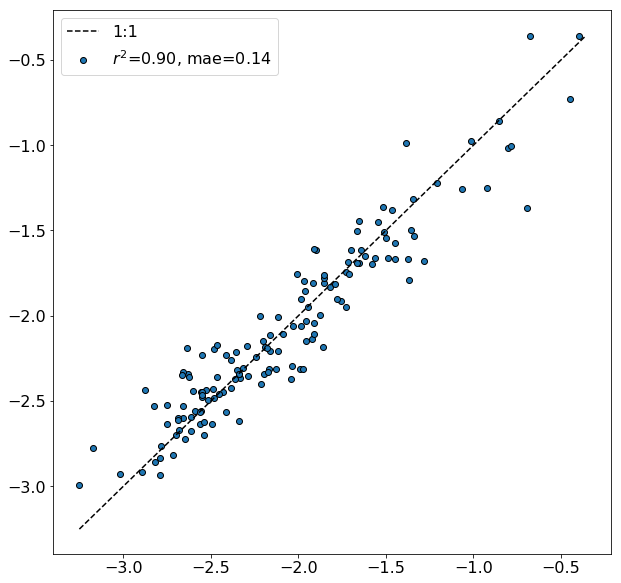

In [74]:
# Check fit on training model
X_shared.set_value(X_s_train)
ppc_train_l1_670hn = bnn_l1_4HL_670hn.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_train.log10_aphy670, ppc_train_l1_670hn, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/train_set_fits/bnn_l1_4HL_670hn.pdf', dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:03<00:00, 561.88it/s]


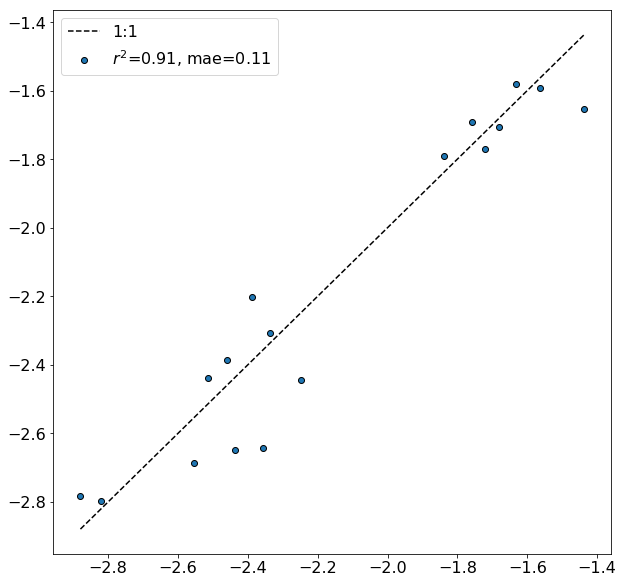

In [75]:
X_shared.set_value(X_s_test)
ppc_test_l1_670hn = bnn_l1_4HL_670hn.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_test.log10_aphy670, ppc_test_l1_670hn, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/test_set_fits/bnn_l1_4HL_670hn.pdf', dpi=300, format='pdf')

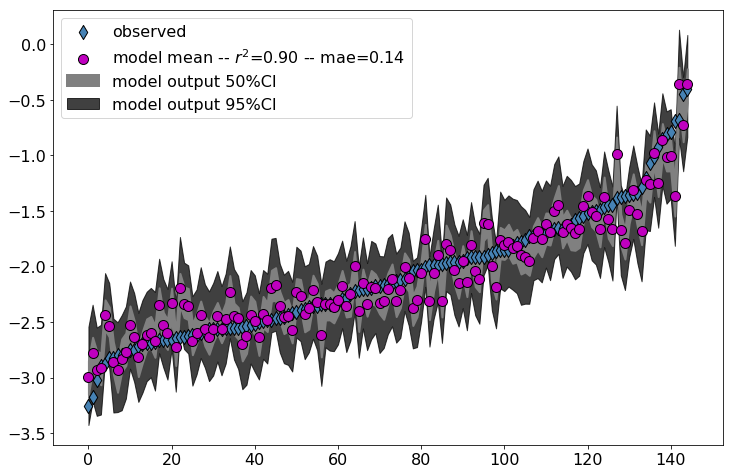

In [96]:
plot_fits_w_estimates(y_train.log10_aphy670, ppc_train_l1_670hn)

In [90]:
bnn_l1_4HL_411hn.model.name = 'L1_4units_411_hn'
bnn_l1_4HL_443_hn.model.name = 'L1_4units_443_hn'
bnn_l1_4HL_489hn.model.name = 'L1_4units_489_hn'
bnn_l1_4HL_510hn.model.name = 'L1_4units_510_hn'
bnn_l1_4HL_555hn.model.name = 'L1_4units_555_hn'
bnn_l1_4HL_670hn.model.name = 'L1_4units_670_hn'

In [91]:
ppc_train_dict = dict(ppc_train_l1_411hn=ppc_train_l1_411hn,
                     ppc_train_l1_443hn=ppc_train_l1_443hn,
                     ppc_train_l1_489hn=ppc_train_l1_489hn,
                     ppc_train_l1_510hn=ppc_train_l1_510hn,
                     ppc_train_l1_555hn=ppc_train_l1_555hn,
                      ppc_train_l1_670hn=ppc_train_l1_670hn,
                     )
ppc_test_dict = dict(ppc_test_l1_411hn=ppc_test_l1_411hn,
                    ppc_test_l1_443hn=ppc_test_l1_443hn,
                    ppc_test_l1_489hn=ppc_test_l1_489hn,
                    ppc_test_l1_510hn=ppc_test_l1_510hn,
                    ppc_test_l1_555hn=ppc_test_l1_555hn,
                    ppc_test_l1_670hn=ppc_test_l1_670hn,
                    )
ppc_dict = dict(train=ppc_train_dict,
                test=ppc_test_dict)
with open('./pickleJar/ppcs/ppc_hn.pkl', 'wb') as fb:
    pickle.dump(ppc_dict, fb)

In [92]:
mdl_dict = {bnn_l1_4HL_411hn.model.name: bnn_l1_4HL_411hn,
            bnn_l1_4HL_443_hn.model.name: bnn_l1_4HL_443_hn,
            bnn_l1_4HL_489hn.model.name: bnn_l1_4HL_489hn,
            bnn_l1_4HL_510hn.model.name: bnn_l1_4HL_510hn,
            bnn_l1_4HL_555hn.model.name: bnn_l1_4HL_555hn,
            bnn_l1_4HL_670hn.model.name: bnn_l1_4HL_670hn}
with open('./pickleJar/Models/BayesianBNN181210/HlfNrmlHypPriors/models.pkl', 'wb') as fb:
    pickle.dump(mdl_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

### Summary Graphs

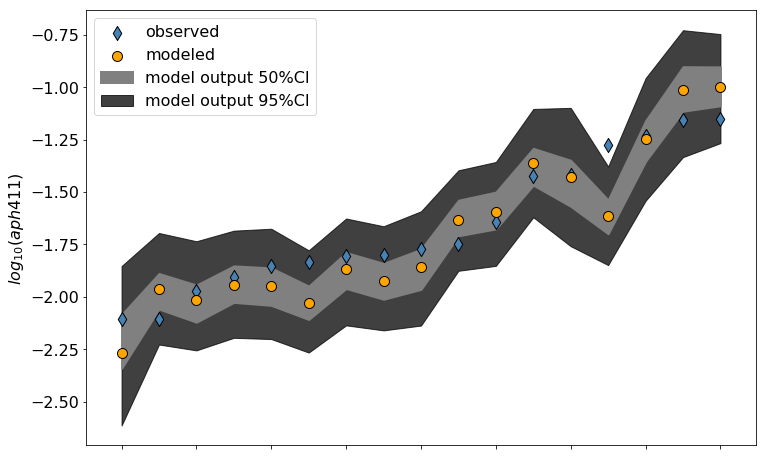

In [50]:
ax = plot_fits_w_estimates(y_test.log10_aphy411, ppc_test_411)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 411)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_411_unc.pdf', dpi=300, format='pdf')

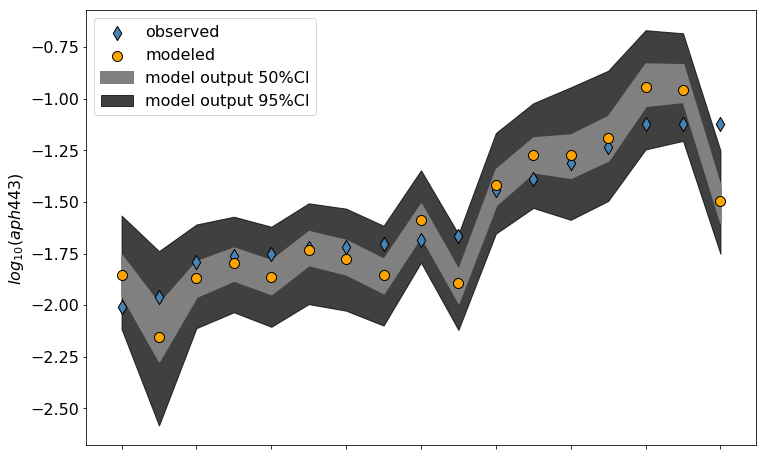

In [51]:
ax = plot_fits_w_estimates(y_test.log10_aphy443, ppc_test_443)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 443)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_443_unc.pdf', dpi=300, format='pdf')

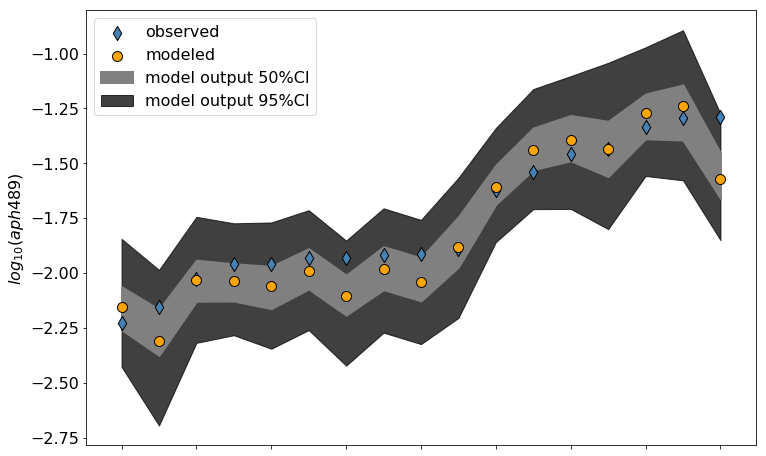

In [52]:
ax = plot_fits_w_estimates(y_test.log10_aphy489, ppc_test_489)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 489)$')
f = pl.gcf()
#f.savefig('./figJar/Single_HL_4_aphi_489_unc.pdf', dpi=300, format='pdf')

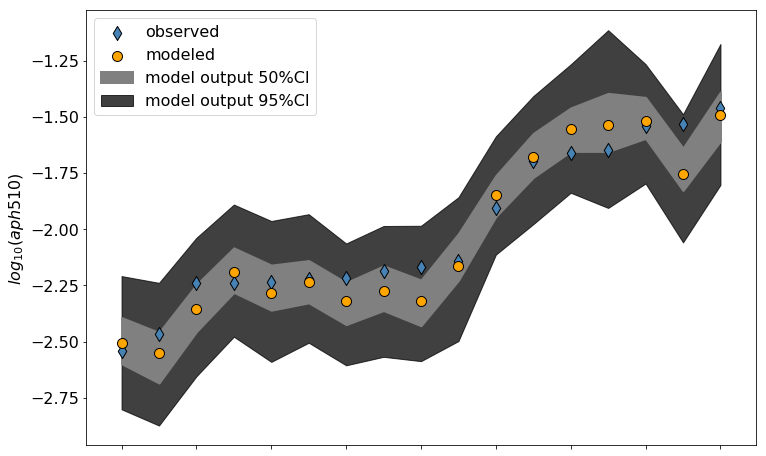

In [53]:
ax = plot_fits_w_estimates(y_test.log10_aphy510, ppc_test_510)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 510)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_510_unc.pdf', dpi=300, format='pdf')

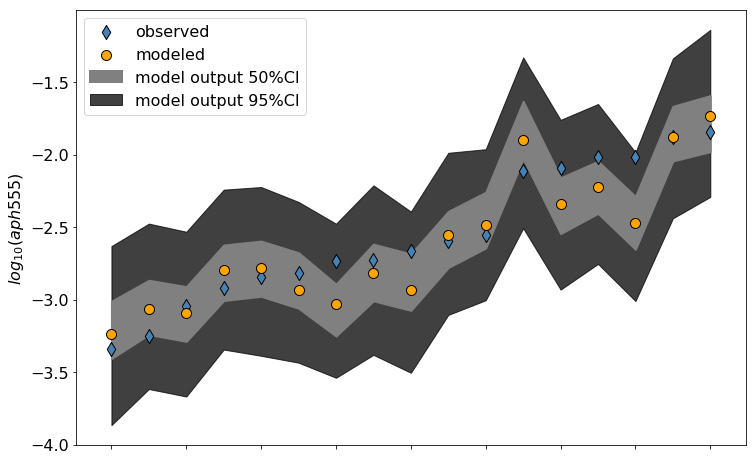

In [54]:
ax = plot_fits_w_estimates(y_test.log10_aphy555, ppc_test_555)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 555)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_555_unc.pdf', dpi=300, format='pdf')

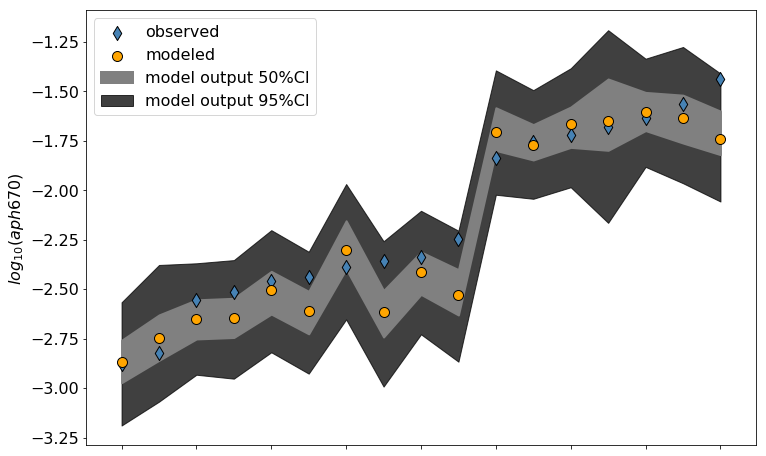

In [55]:
ax = plot_fits_w_estimates(y_test.log10_aphy670, ppc_test_670)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 670)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_670_unc.pdf', dpi=300, format='pdf')

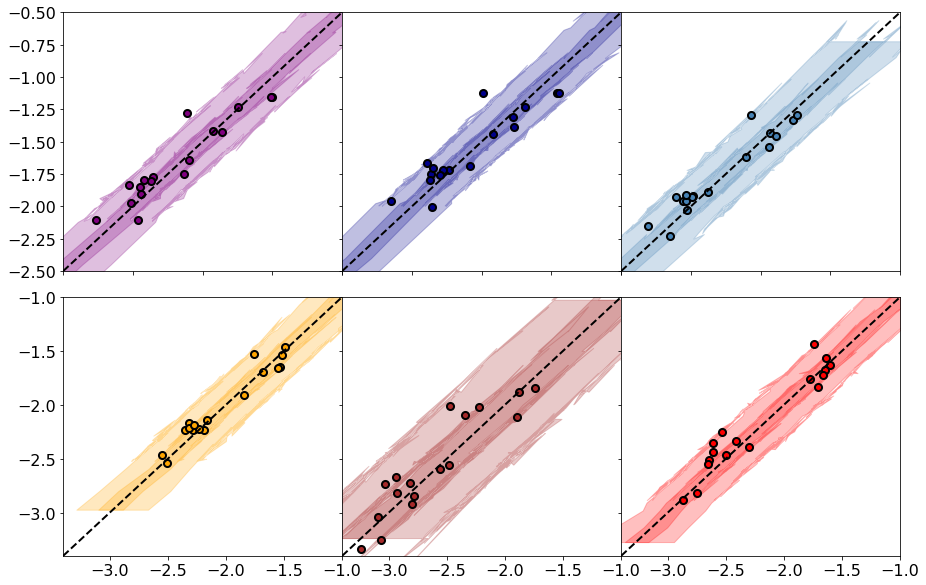

In [56]:
f, axs = pl.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.ravel()
f.subplots_adjust(wspace=0, hspace=0.1)

uncertainty_plot_2(ppc_train_l1_411, ppc_test_411, y_test.log10_aphy411.values, y_train.log10_aphy411.values,
                  ax=axs[0], band_color='purple')
uncertainty_plot_2(ppc_train_l1_443, ppc_test_443, y_test.log10_aphy443.values, y_train.log10_aphy443.values,
                  ax=axs[1], band_color='darkblue')
uncertainty_plot_2(ppc_train_l1_489, ppc_test_489, y_test.log10_aphy489.values, y_train.log10_aphy489.values,
                  ax=axs[2], band_color='steelblue')
uncertainty_plot_2(ppc_train_l1_510, ppc_test_510, y_test.log10_aphy510.values, y_train.log10_aphy510.values,
                  ax=axs[3], band_color='orange')
uncertainty_plot_2(ppc_train_l1_555, ppc_test_555, y_test.log10_aphy555.values, y_train.log10_aphy555.values,
                  ax=axs[4], band_color='brown')
uncertainty_plot_2(ppc_train_l1_670, ppc_test_670, y_test.log10_aphy670.values, y_train.log10_aphy670.values,
                  ax=axs[5], band_color='red')
for i, ax in enumerate(axs):
    
    if i < 3:
        min_, max_ = -2.5, -0.5
        ax.set_xticklabels([])
    else:
        min_, max_ = -3.4, -1
    if i %3 != 0:
        ax.set_yticklabels([])
    ax.plot([min_, max_], [min_, max_], ls='--', color='k', lw=2, label='')
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)

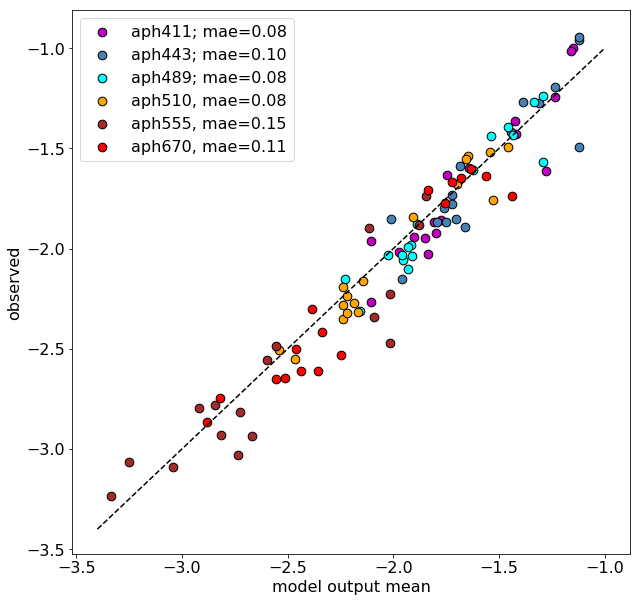

In [57]:
f, ax_ = pl.subplots(figsize=(10, 10))
plot_obs_against_ppc(y_test.log10_aphy411, ppc_test_411, color='m', label='aph411; mae=%.2f' % mae_test_411, s=75, ax=ax_) 
plot_obs_against_ppc(y_test.log10_aphy443, ppc_test_443, color='steelblue', ax=ax_, label='aph443; mae=%.2f' % mae_test_443, s=75,)
plot_obs_against_ppc(y_test.log10_aphy489, ppc_test_489, color='cyan', ax=ax_, label='aph489; mae=%.2f' % mae_test_489, s=75, )
plot_obs_against_ppc(y_test.log10_aphy510, ppc_test_510, color='orange', ax=ax_, label='aph510, mae=%.2f' % mae_test_510, s=75,)
plot_obs_against_ppc(y_test.log10_aphy555, ppc_test_555, color='brown', ax=ax_, label='aph555, mae=%.2f' % mae_test_555, s=75, )
plot_obs_against_ppc(y_test.log10_aphy670, ppc_test_670, color='red', ax=ax_, label='aph670, mae=%.2f' % mae_test_670, s=75, )
ax_.plot([-3.4, -1], [-3.4, -1], color='k', ls='--')
ax_.legend()
ax_.set_xlabel('model output mean')
ax_.set_ylabel('observed')
f.savefig('./figJar/Single_HL_4_aphi_test_sets.pdf', format='pdf', dpi=300)

In [129]:
bnn_l1_4HL_411.model.name = 'bnn_l1_4HL_411'
bnn_l1_4HL_443.model.name = 'bnn_l1_4HL_443'
bnn_l1_4HL_489.model.name = 'bnn_l1_4HL_489'
bnn_l1_4HL_510.model.name = 'bnn_l1_4HL_510'
bnn_l1_4HL_555.model.name = 'bnn_l1_4HL_555'
bnn_l1_4HL_670.model.name = 'bnn_l1_4HL_670'

In [130]:
pickledModelDict = {bnn_l1_4HL_411.model.name: bnn_l1_4HL_411,
                    bnn_l1_4HL_443.model.name: bnn_l1_4HL_443,
                    bnn_l1_4HL_489.model.name: bnn_l1_4HL_489,
                    bnn_l1_4HL_510.model.name: bnn_l1_4HL_510,
                    bnn_l1_4HL_555.model.name: bnn_l1_4HL_555,
                    bnn_l1_4HL_670.model.name: bnn_l1_4HL_670
                   }
with open('./pickleJar/Models/Aphi_ALL_BNN_4_HL1_ARD.pkl', 'wb') as f:
    pickle.dump(pickledModelDict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
np.log10(0.001)

-3.0

In [61]:
10**-3.5

0.00031622776601683794